<a href="https://colab.research.google.com/github/freida20git/nanoparticle-classification/blob/main/triangles/Cut_Triangles_SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Automatically generating object masks with SAM

Since SAM can efficiently process prompts, masks for the entire image can be generated by sampling a large number of prompts over an image. This method was used to generate the dataset SA-1B.

The class `SamAutomaticMaskGenerator` implements this capability. It works by sampling single-point input prompts in a grid over the image, from each of which SAM can predict multiple masks. Then, masks are filtered for quality and deduplicated using non-maximal suppression. Additional options allow for further improvement of mask quality and quantity, such as running prediction on multiple crops of the image or postprocessing masks to remove small disconnected regions and holes.

In [ ]:
from IPython.display import display, HTML
display(HTML(
"""
<a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/automatic_mask_generator_example.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>
"""
))

## Environment Set-up

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [ ]:
using_colab = True

In [ ]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    !{sys.executable} -m pip install opencv-python matplotlib
    !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'

    !mkdir images
    !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg

    !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

PyTorch version: 2.6.0+cu124
Torchvision version: 0.21.0+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-gq5g7d3y
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-gq5g7d3y
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36592 sha256=156d80618280386e737ffe89348e743ae5f2e39a74cf04ae3d1e5d937085f941
  Stored in directory: /tmp/pip-ephem-wheel-cache-922q_jr0/wheels/15/d7/bd/05f5f23b7dcbe70cbc6783b06f12143b0cf1a5da5c7b52dcc5
Successfully built segment_anything
--2025-06-23 08:32:36--  https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com

## Set-up

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Example image

In [ ]:
image = cv2.imread("drive/MyDrive/pictures_data/triangles_train1.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

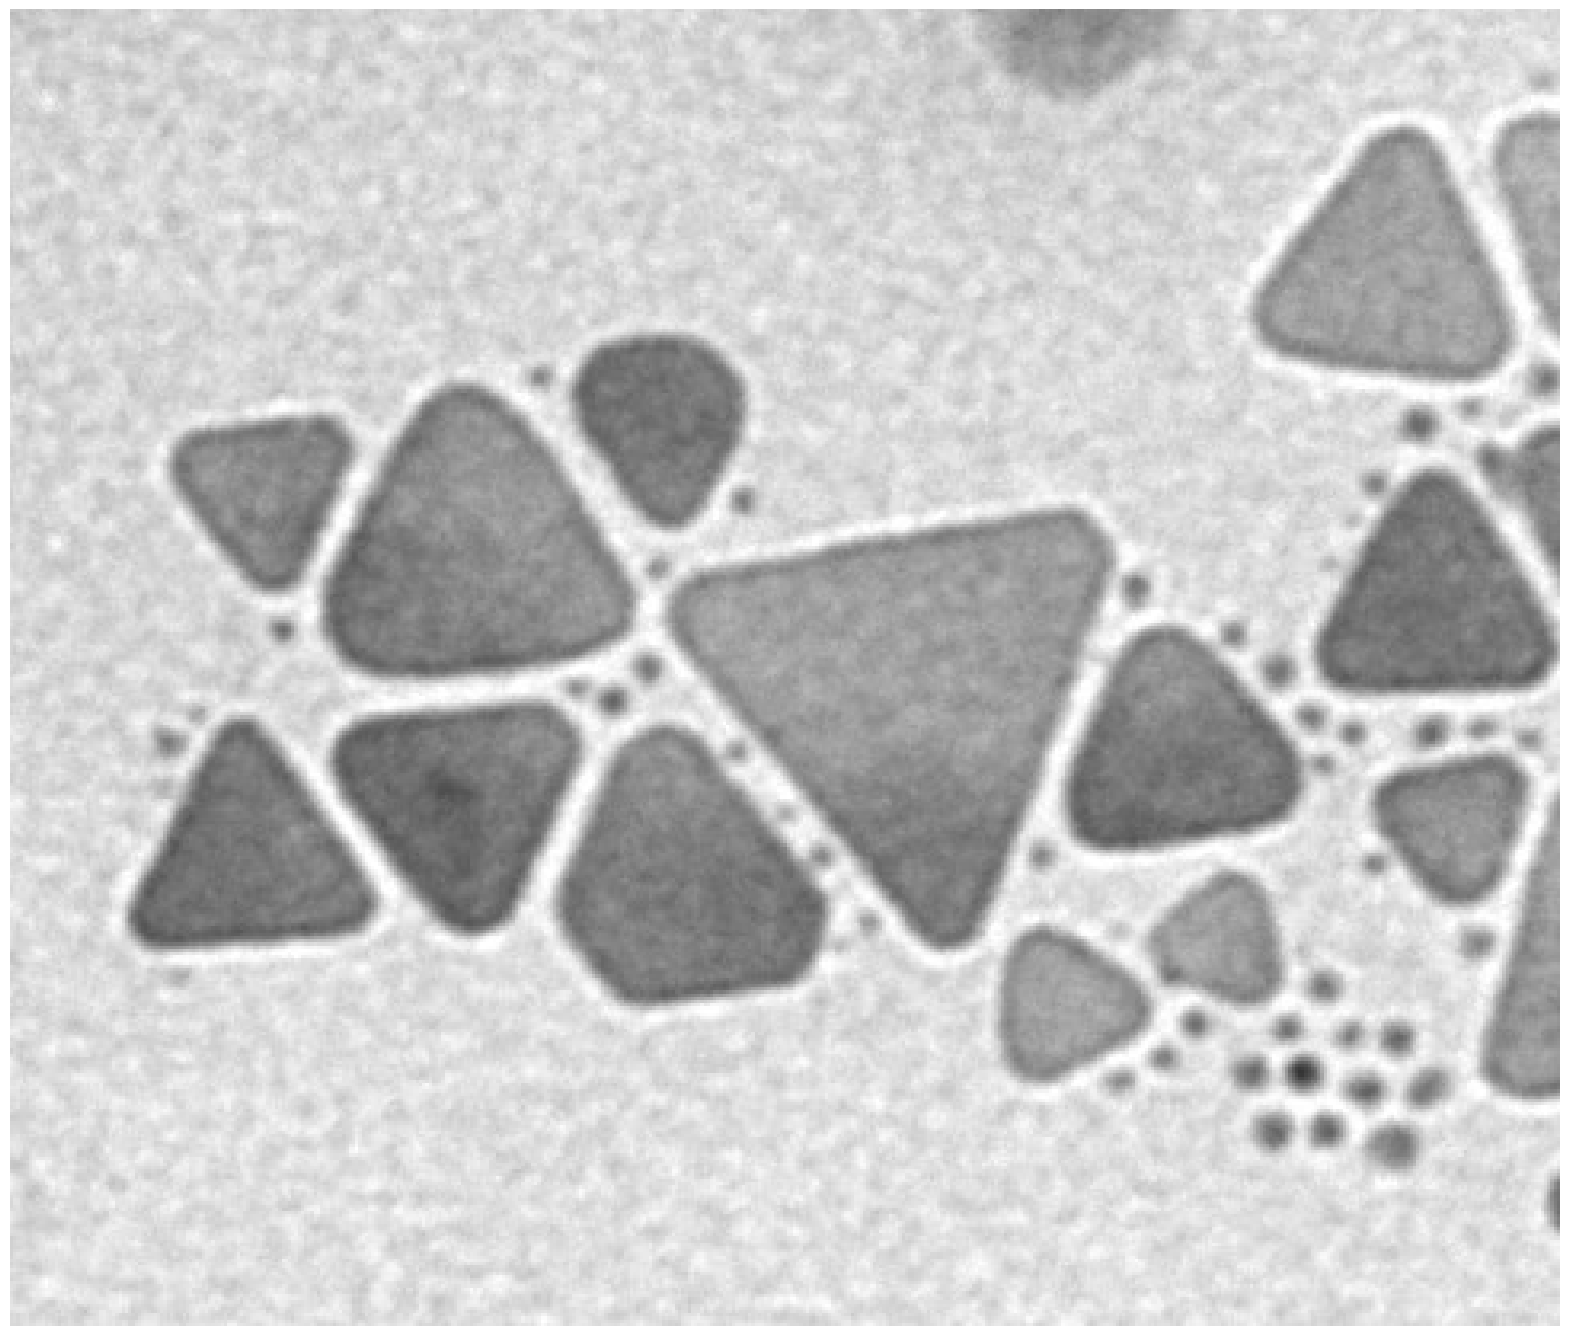

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [ ]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=64,                  # increase resolution
    pred_iou_thresh=0.95,                 # only high-confidence masks
    stability_score_thresh=0.95,         # masks must be stable
    box_nms_thresh=0.3,                  # reduce overlapping masks
    min_mask_region_area=500             # remove tiny spurious masks
)

To generate masks, just run `generate` on an image.

In [ ]:
masks = mask_generator.generate(image)

Mask generation returns a list over masks, where each mask is a dictionary containing various data about the mask. These keys are:
* `segmentation` : the mask
* `area` : the area of the mask in pixels
* `bbox` : the boundary box of the mask in XYWH format
* `predicted_iou` : the model's own prediction for the quality of the mask
* `point_coords` : the sampled input point that generated this mask
* `stability_score` : an additional measure of mask quality
* `crop_box` : the crop of the image used to generate this mask in XYWH format

In [ ]:
print(len(masks))
print(masks[0].keys())
print(masks[1]["crop_box"])

Show all the masks overlayed on the image.

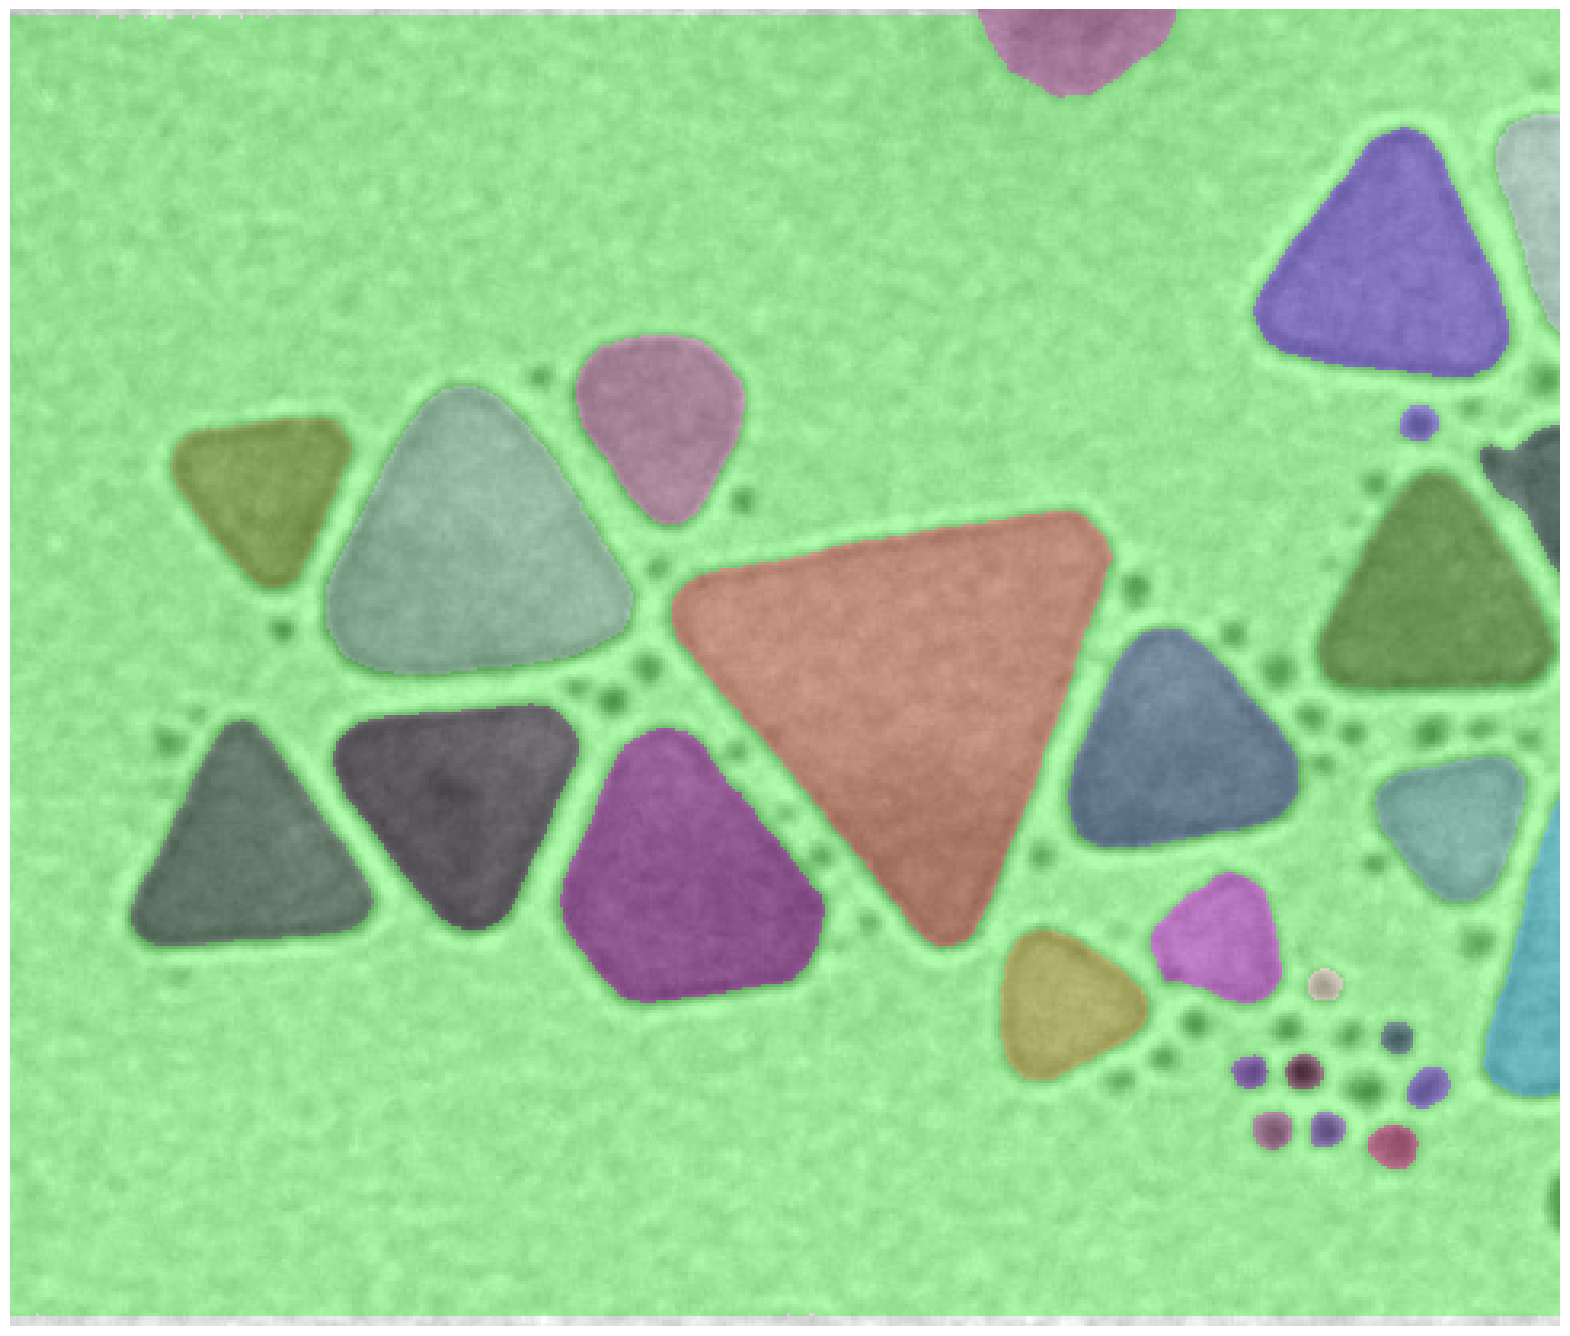

In [ ]:
plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def mask_to_xywh(mask, padding=10, image_shape=None):
    """Return both original bbox and bbox with padding."""
    mask = np.array(mask).astype(np.uint8)
    coords = cv2.findNonZero(mask)
    if coords is None:
        return None, None

    x, y, w, h = cv2.boundingRect(coords)
    bbox = (x, y, w, h)  # ללא padding

    if image_shape is not None:
        img_h, img_w = image_shape[:2]
        x1 = max(0, x - padding)
        y1 = max(0, y - padding)
        x2 = min(img_w, x + w + padding)
        y2 = min(img_h, y + h + padding)
        padded_bbox = (x1, y1, x2 - x1, y2 - y1)
    else:
        padded_bbox = bbox

    return bbox, padded_bbox


def draw_bbox_xywh(image, bbox, color=(255, 0, 0), thickness=2):
    """Draw a bounding box in XYWH format on an image."""
    x, y, w, h = bbox
    image_with_bbox = image.copy()
    cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), color, thickness)
    return image_with_bbox


# Start with the original image
image_with_bbox = image.copy()

# Loop through all masks and draw bounding boxes
for i in range(len(masks)):
    mask = masks[i]["segmentation"]
    bbox, _= mask_to_xywh(mask)
    if bbox is not None:
        image_with_bbox = draw_bbox_xywh(image_with_bbox, bbox, color=(255, 0, 0), thickness=2)

# Show the result
plt.imshow(cv2.cvtColor(image_with_bbox, cv2.COLOR_BGR2RGB))
plt.title("Image with Bounding Boxes")
plt.axis('off')
plt.show()

In [ ]:
import matplotlib.pyplot as plt

def draw_image_with_mask(image, bbox, color=(255, 0, 0), thickness=2):
    """Draw a bounding box in XYWH format on an image."""
    x, y, w, h = bbox
    #image_with_bbox = image.copy()
    #cv2.rectangle(image_with_bbox, (x, y), (x + w, y + h), color, thickness)
    cropped = image[y:y+h, x:x+w]
    height, width = cropped.shape[:2]
    dpi = 100  # or use 96 depending on your screen

    plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
    plt.imshow(cropped, cmap='gray')  # remove cmap if image is RGB
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.show()
    return

for i in range(len(masks)):
  _, padded_bbox = mask_to_xywh(masks[i]["segmentation"])

# Draw bounding box in RED on image
  draw_image_with_mask(image, padded_bbox, color=(255, 0, 0), thickness=2)

In [ ]:
def crop_with_padding(image, bbox, padding=10):
    """Crop an image with padding around the bounding box."""
    x, y, w, h = bbox

    # הוספת padding בזמן החיתוך
    x = max(x - padding, 0)
    y = max(y - padding, 0)
    w = w + 2 * padding
    h = h + 2 * padding

    # ודא שהחיתוך לא חורג מגבולות התמונה
    img_h, img_w = image.shape[:2]
    w = min(w, img_w - x)
    h = min(h, img_h - y)

    return image[y:y+h, x:x+w]

In [ ]:
def display_cropped_regions(image, bboxes):
    """Display cropped regions of the image based on a list of bounding boxes."""
    for bbox in bboxes:
        x, y, w, h = bbox
        cropped = image[y:y+h, x:x+w]
        height, width = cropped.shape[:2]
        dpi = 100  # Or use 96 depending on your screen

        plt.figure(figsize=(width / dpi, height / dpi), dpi=dpi)
        plt.imshow(cropped, cmap='gray')  # Use 'gray' for grayscale or remove cmap for RGB
        plt.axis('off')
        plt.tight_layout(pad=0)
        plt.show()


In [ ]:
import os
import cv2
import numpy as np

def save_masks(image, masks, original_img_forFileName):
    masks_dir = "drive/MyDrive/triangle_val"
    os.makedirs(masks_dir, exist_ok=True)

    for i, mask_dict in enumerate(masks):
        sam_mask = mask_dict["segmentation"]
        bbox, padded_bbox = mask_to_xywh(sam_mask, padding=10, image_shape=image.shape)

        if bbox is None or padded_bbox is None:
            continue

        # חיתוך המסכה עם padding
        cropped_mask = sam_mask[
            padded_bbox[1]:padded_bbox[1] + padded_bbox[3],
            padded_bbox[0]:padded_bbox[0] + padded_bbox[2]
        ]

        # שם קובץ לפי bbox המקורי (ללא padding)
        x1, y1, w, h = bbox
        x2 = x1 + w
        y2 = y1 + h
        filename = f"{original_img_forFileName}_{x1}_{y1}_{x2}_{y2}.jpg"

        # המרה לשמירה תקינה
        cropped_mask_uint8 = (cropped_mask.astype(np.uint8)) * 255

        # שמירת המסכה
        cv2.imwrite(os.path.join(masks_dir, filename), cropped_mask_uint8)

    print("Saving masks completed.")


original_img_forFileName = "triangles_valid1"
save_masks(image, masks, original_img_forFileName)